In [5]:
%%capture
!cd /content/
!rm -rf /content/apex && git clone https://github.com/NVIDIA/apex
!pip install -v --disable-pip-version-check --no-cache-dir /content/apex

!pip install pytorch-ignite

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [7]:
import json
from PIL import Image
import cv2

import pandas as pd

import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.transforms import Compose, RandomCrop, Pad, RandomHorizontalFlip, Resize
from torchvision.transforms import ToTensor, Normalize
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torchvision import datasets

from torch.utils.data import Dataset, Subset, DataLoader

from torch.optim.lr_scheduler import ExponentialLR

import torch.optim as optim
import torch.nn.functional as F

from collections import OrderedDict

import torchvision.transforms as transforms
from torchvision.datasets.cifar import CIFAR100 
from torchvision.transforms import Compose, RandomCrop, Pad, RandomHorizontalFlip, Resize
from torchvision.transforms import ToTensor, Normalize

from torch.utils.data import Subset
from torch.utils.data import DataLoader

import torchvision.utils as vutils

import torch.optim as optim



import random
#import ignite


# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from itertools import chain
from PIL.Image import BICUBIC
from collections import OrderedDict
import math

from tqdm import tqdm

## Download Data

In [8]:
import os
from google.colab import drive

drive.mount('/gdrive',force_remount=True)
if not os.path.isdir('/content/img_cut'):
  %cp -r /gdrive/MyDrive/img_cut /content/

Mounted at /gdrive


## Check object size distributions

- useful for choosing the right neural net classifier

In [9]:
sizes = []
for root, dir, files in os.walk("/content/img_cut/img/"):
  for i in files:
    img = Image.open("/content/img_cut/img/"+i)
    sizes.append(img.size)


def histoplotter(x, y, range_):
  # Plotter
  # CITATION: Ryan Dorrill 2018

  fig = plt.figure()          #create a canvas
  ax = fig.add_subplot(111, projection='3d')

  # histogram 
  hist, xedges, yedges = np.histogram2d(x, y, bins=(20,20),range = [[0,range_],[0,range_]],)
  xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

  xpos = xpos.flatten()/2.
  ypos = ypos.flatten()/2.
  zpos = np.zeros_like (xpos)

  dx = xedges [1] - xedges [0]
  dy = yedges [1] - yedges [0]
  dz = hist.flatten()

  cmap = cm.get_cmap('jet') 
  max_height = np.max(dz)   
  min_height = np.min(dz)
  # scale each z to [0,1], and get their rgb values
  rgba = [cmap((k-min_height)/max_height) for k in dz] 

  ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
  plt.title("object size histogram")
  plt.xlabel("Width")
  plt.ylabel("Height")
  #plt.savefig("")
  plt.show()


<ipython-input-9-f5bda08c34a1>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


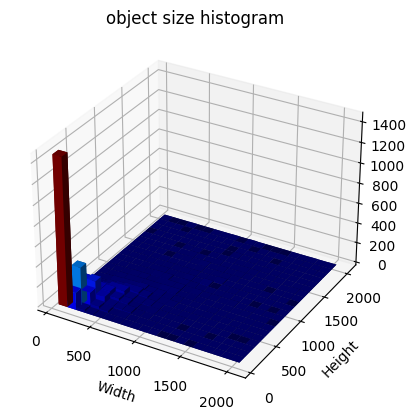

In [10]:
xAmplitudes = [i[0] for i in sizes]
yAmplitudes = [i[1] for i in sizes]
histoplotter(xAmplitudes,yAmplitudes,2000)

<ipython-input-9-f5bda08c34a1>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


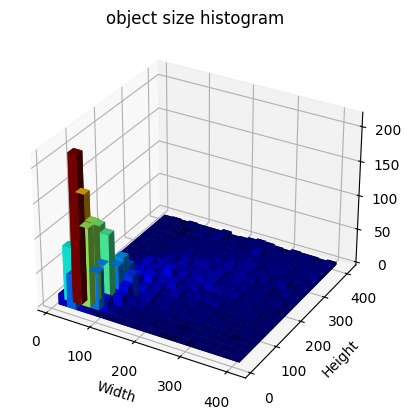

In [11]:
histoplotter(xAmplitudes,yAmplitudes,400)

EfficientNet models parametrization:
```
# (width_coefficient, depth_coefficient, resolution, dropout_rate)
'efficientnet-b0': (1.0, 1.0, 224, 0.2),
'efficientnet-b1': (1.0, 1.1, 240, 0.2),
'efficientnet-b2': (1.1, 1.2, 260, 0.3),
'efficientnet-b3': (1.2, 1.4, 300, 0.3),
'efficientnet-b4': (1.4, 1.8, 380, 0.4),
'efficientnet-b5': (1.6, 2.2, 456, 0.4),
'efficientnet-b6': (1.8, 2.6, 528, 0.5),
'efficientnet-b7': (2.0, 3.1, 600, 0.5),
```    


See histogram. Most of our objects are smaller than 200, so `EfficientNet-B0` will be well enough for our classification task.

## build EfficientNet


In [12]:
#@title EfficientNet
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)


class Flatten(nn.Module):
    
    def forward(self, x):
        return x.reshape(x.shape[0], -1)

class SqueezeExcitation(nn.Module):
    
    def __init__(self, inplanes, se_planes):
        super(SqueezeExcitation, self).__init__()
        self.reduce_expand = nn.Sequential(
            nn.Conv2d(inplanes, se_planes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            Swish(),
            nn.Conv2d(se_planes, inplanes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_se = torch.mean(x, dim=(-2, -1), keepdim=True)
        x_se = self.reduce_expand(x_se)
        return x_se * x


def init_weights(module):    
    if isinstance(module, nn.Conv2d):    
        nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out')
    elif isinstance(module, nn.Linear):
        init_range = 1.0 / math.sqrt(module.weight.shape[1])
        nn.init.uniform_(module.weight, a=-init_range, b=init_range)
        

class MBConv(nn.Module):

    def __init__(self, inplanes, planes, kernel_size, stride, 
                 expand_rate=1.0, se_rate=0.25, 
                 drop_connect_rate=0.2):
        super(MBConv, self).__init__()

        expand_planes = int(inplanes * expand_rate)
        se_planes = max(1, int(inplanes * se_rate))

        self.expansion_conv = None        
        if expand_rate > 1.0:
            self.expansion_conv = nn.Sequential(
                nn.Conv2d(inplanes, expand_planes, 
                          kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
                Swish()
            )
            inplanes = expand_planes

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(inplanes, expand_planes,
                      kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size // 2, groups=expand_planes,
                      bias=False),
            nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
            Swish()
        )

        self.squeeze_excitation = SqueezeExcitation(expand_planes, se_planes)
        
        self.project_conv = nn.Sequential(
            nn.Conv2d(expand_planes, planes, 
                      kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes, momentum=0.01, eps=1e-3),
        )

        self.with_skip = stride == 1
        self.drop_connect_rate = drop_connect_rate
    
    def _drop_connect(self, x):        
        keep_prob = 1.0 - self.drop_connect_rate
        drop_mask = torch.rand(x.shape[0], 1, 1, 1) + keep_prob
        drop_mask = drop_mask.type_as(x)
        drop_mask.floor_()
        return drop_mask * x / keep_prob
        
    def forward(self, x):
        z = x
        if self.expansion_conv is not None:
            x = self.expansion_conv(x)

        x = self.depthwise_conv(x)
        x = self.squeeze_excitation(x)
        x = self.project_conv(x)
        
        # Add identity skip
        if x.shape == z.shape and self.with_skip:            
            if self.training and self.drop_connect_rate is not None:
                x = self._drop_connect(x)
            x += z
        return x
       
class EfficientNet(nn.Module):

  '''
  CITATION: 
  EfficientNET: Tan et al. 2019
  Implementation: PyTorch

  '''
  def _setup_repeats(self, num_repeats):
      return int(math.ceil(self.depth_coefficient * num_repeats))
  
  def _setup_channels(self, num_channels):
      num_channels *= self.width_coefficient
      new_num_channels = math.floor(num_channels / self.divisor + 0.5) * self.divisor
      new_num_channels = max(self.divisor, new_num_channels)
      if new_num_channels < 0.9 * num_channels:
          new_num_channels += self.divisor
      return new_num_channels

  def __init__(self, num_classes=1000, 
                width_coefficient=1.0,
                depth_coefficient=1.0,
                se_rate=0.25,
                dropout_rate=0.2,
                drop_connect_rate=0.2):
      super(EfficientNet, self).__init__()
      
      self.width_coefficient = width_coefficient
      self.depth_coefficient = depth_coefficient
      self.divisor = 8
              
      list_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
      list_channels = [self._setup_channels(c) for c in list_channels]
              
      list_num_repeats = [1, 2, 2, 3, 3, 4, 1]
      list_num_repeats = [self._setup_repeats(r) for r in list_num_repeats]        
      
      expand_rates = [1, 6, 6, 6, 6, 6, 6]
      strides = [1, 2, 2, 2, 1, 2, 1]
      kernel_sizes = [3, 3, 5, 3, 5, 5, 3]

      # Define stem:
      self.stem = nn.Sequential(
          nn.Conv2d(3, list_channels[0], kernel_size=3, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(list_channels[0], momentum=0.01, eps=1e-3),
          Swish()
      )
      
      # Define MBConv blocks
      blocks = []
      counter = 0
      num_blocks = sum(list_num_repeats)
      for idx in range(7):
          
          num_channels = list_channels[idx]
          next_num_channels = list_channels[idx + 1]
          num_repeats = list_num_repeats[idx]
          expand_rate = expand_rates[idx]
          kernel_size = kernel_sizes[idx]
          stride = strides[idx]
          drop_rate = drop_connect_rate * counter / num_blocks
          
          name = "MBConv{}_{}".format(expand_rate, counter)
          blocks.append((
              name,
              MBConv(num_channels, next_num_channels, 
                      kernel_size=kernel_size, stride=stride, expand_rate=expand_rate, 
                      se_rate=se_rate, drop_connect_rate=drop_rate)
          ))
          counter += 1
          for i in range(1, num_repeats):                
              name = "MBConv{}_{}".format(expand_rate, counter)
              drop_rate = drop_connect_rate * counter / num_blocks                
              blocks.append((
                  name,
                  MBConv(next_num_channels, next_num_channels, 
                          kernel_size=kernel_size, stride=1, expand_rate=expand_rate, 
                          se_rate=se_rate, drop_connect_rate=drop_rate)                                    
              ))
              counter += 1
      
      self.blocks = nn.Sequential(OrderedDict(blocks))
      
      # Define head
      self.head = nn.Sequential(
          nn.Conv2d(list_channels[-2], list_channels[-1], 
                    kernel_size=1, bias=False),
          nn.BatchNorm2d(list_channels[-1], momentum=0.01, eps=1e-3),
          Swish(),
          nn.AdaptiveAvgPool2d(1),
          Flatten(),
          nn.Dropout(p=dropout_rate),
          nn.Linear(list_channels[-1], num_classes)
      )

      self.apply(init_weights)
      
  def forward(self, x):
      f = self.stem(x)
      f = self.blocks(f)
      y = self.head(f)
      return y

In [13]:
model = EfficientNet(width_coefficient=1.0, depth_coefficient=1.0, 
                     dropout_rate=0.2)

## load pre-trained weights


In [14]:
# !mkdir /tmp/
# !wget http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth -O/tmp/efficientnet-b0-08094119.pth

In [15]:
# model_state = torch.load("/tmp/efficientnet-b0-08094119.pth")

# # A basic remapping is required
# mapping = {
#     k: v for k, v in zip(model_state.keys(), model.state_dict().keys())
# }
# mapped_model_state = OrderedDict([
#     (mapping[k], v) for k, v in model_state.items()
# ])

# model.load_state_dict(mapped_model_state, strict=False)

In [16]:
model.head[6] = nn.Linear(1280, 5)
#model.head[6].in_features, model.head[6].out_features

In [17]:
assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled, "NVIDIA/Apex:Amp requires cudnn backend to be enabled."

In [18]:
torch.backends.cudnn.benchmark = True
device = "cuda"
model = model.to(device)

## Optimizer & learning rate

In [19]:
LEARNING_RATE = 0.1


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([
    {
        "params": chain(model.stem.parameters(), model.blocks.parameters()),
        "lr": LEARNING_RATE * 0.1,
    },
    {
        "params": model.head[:6].parameters(),
        "lr": LEARNING_RATE * 0.2,
    },    
    {
        "params": model.head[6].parameters(), 
        "lr": LEARNING_RATE
    }], 
    momentum=0.9, weight_decay=0.001, nesterov=True)

lr_scheduler = ExponentialLR(optimizer, gamma=0.975)

In [21]:
from ignite.utils import convert_tensor


def update_fn(engine, batch):
    model.train()

    x = convert_tensor(batch[0], device=device, non_blocking=True)
    y = convert_tensor(batch[1], device=device, non_blocking=True)
    
    y_pred = model(x)
    
    # Compute loss 
    loss = criterion(y_pred, y)    

    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()

    optimizer.step()
    
    return {
        "batchloss": loss.item(),
    }    

### Initialize Amp



In [22]:
from apex import amp

# Initialize Amp
model, optimizer = amp.initialize(model, optimizer, opt_level="O0", num_losses=1)


Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0


/usr/local/lib/python3.10/dist-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.amp is deprecated and will be removed by the end of February 2023. Use [PyTorch AMP](https://pytorch.org/docs/stable/amp.html)
  warnings.warn(msg, DeprecatedFeatureWarning)


## Data Pipeline

In [23]:
!wget https://raw.githubusercontent.com/running-man-01/utilities/main/material_key.csv
mkey = pd.read_csv('./material_key.csv')
mkey_dict = {i:j for i,j in zip(mkey.cat_id, mkey.m_id)}

--2023-05-05 18:07:56--  https://raw.githubusercontent.com/running-man-01/utilities/main/material_key.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1829 (1.8K) [text/plain]
Saving to: ‘material_key.csv’

material_key.csv    100%[===================>]   1.79K  --.-KB/s    in 0s      

2023-05-05 18:07:57 (38.3 MB/s) - ‘material_key.csv’ saved [1829/1829]



In [24]:
def TACO_label_getter(data=None):
  train_test_ids = np.load('/gdrive/MyDrive/TACO_trte_split.npz')
  if data == 'train': 
    img_ids = train_test_ids['train'].tolist()
  elif data == 'test': 
    img_ids = train_test_ids['test'].tolist()
  elif data == 'val': 
    img_ids = train_test_ids['val'].tolist()

  for _,_,files in os.walk('/content/img_cut/lbl/'):
    cache = []
    for i in files: #tqdm(files):
      if int(re.split('_',i)[0]) not in img_ids:
        pass
      else:
        cache1 = np.load('/content/img_cut/lbl/'+str(i),allow_pickle=True)
        cache1 = cache1['arr_0'].tolist()['category_id']
        cache.append([str(i),cache1])

  return pd.DataFrame(cache)

# TACO_label_getter(train=True)

In [25]:
import re

class TACO_Data(Dataset):
    def __init__(self, anno_obj, img_dir, transform=None, target_transform=None):
        self.img_labels = anno_obj
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        name = str(self.img_labels.iloc[idx, 0]).replace('.npz','.jpg')
        img_path = os.path.join(self.img_dir, str(name))
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx,1]
        label = int(mkey_dict[label])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Transforms

(447, 1322)
torch.Size([1, 3, 224, 224])


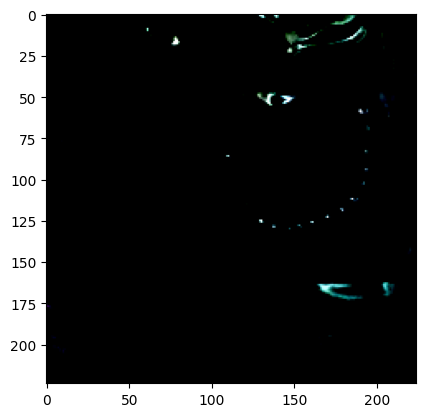

In [26]:
class SquarePad(object):
  #CITATION: Naofumi Tomita 2021
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return TF.pad(image, padding, 0, 'constant')


img = Image.open("/content/img_cut/img/0_1.jpg")
print(img.size)
# Preprocess image
image_size = 224
object_multiplier=1.2 #read objects slightly larger, than cut it randomly. this is a way of data augmentation

tfms = Compose([
                #SquarePad(),
                Resize(256, BICUBIC),
                RandomCrop((image_size,image_size)),
                RandomHorizontalFlip(),
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

x = tfms(img).unsqueeze(0)
print(x.size())
plt.imshow(x[0].permute(1, 2, 0))


### Dataloader & batch size & number of loader workers

In [27]:
BATCH_SIZE = 128
NUM_WORKER = 8

In [28]:
train_data_obj = TACO_Data(
    anno_obj = TACO_label_getter(data='train'),
    img_dir = "/content/img_cut/img",
    transform = tfms,
    target_transform = None
)

test_data_obj = TACO_Data(
    anno_obj = TACO_label_getter(data='test'),
    img_dir = "/content/img_cut/img",
    transform = tfms,
    target_transform = None
)

val_data_obj = TACO_Data(
    anno_obj = TACO_label_getter(data='val'),
    img_dir = "/content/img_cut/img",
    transform = tfms,
    target_transform = None
)

# load
train_loader = DataLoader(
                        train_data_obj, 
                        batch_size=BATCH_SIZE,
                        shuffle=True, 
                        num_workers=NUM_WORKER,
                        drop_last=True,
                        pin_memory=True)

test_loader = DataLoader(test_data_obj, 
                         batch_size=32, 
                         num_workers=0, 
                         shuffle=False, drop_last=False, pin_memory=True)

eval_train_loader = DataLoader(val_data_obj, batch_size=32, num_workers=0, 
                               shuffle=False, drop_last=False, pin_memory=True)


In [29]:
# from time import time
# import multiprocessing as mp
# for num_workers in range(2, mp.cpu_count(), 2):  
#     train_loader = DataLoader(train_data_obj,shuffle=True,num_workers=num_workers,batch_size=64,pin_memory=True)
#     start = time()
#     for epoch in range(1, 3):
#         for i, data in enumerate(train_loader, 0):
#             pass
#     end = time()
#     print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

In [30]:
# batch = next(iter(train_loader))

# res = update_fn(engine=None, batch=batch)

# # batch = None
# # torch.cuda.empty_cache()

# res

## visualize

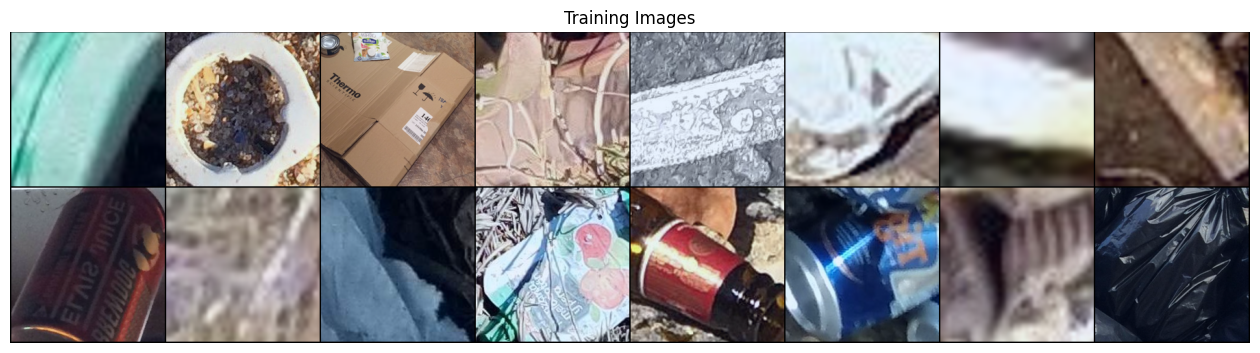

In [31]:
import torchvision.utils as vutils

# Plot some training images
batch = next(iter(train_loader))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow( 
    vutils.make_grid(batch[0][:16], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))
)

batch = None
torch.cuda.empty_cache()

## build Trainer

In [32]:
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import RunningAverage, Accuracy, Precision, Recall, Loss, TopKCategoricalAccuracy

from ignite.contrib.handlers import TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler

In [33]:
trainer = Engine(update_fn)


def output_transform(out):
    return out['batchloss']


RunningAverage(output_transform=output_transform).attach(trainer, "batchloss")

In [34]:
from datetime import datetime

exp_name = datetime.now().strftime("%Y%m%d-%H%M%S")
log_path = "/tmp/TACO_EfficientNET_classify/{}".format(exp_name)
tb_logger = TensorboardLogger(log_dir=log_path)


tb_logger.attach(trainer, 
                 log_handler=OutputHandler('training', ['batchloss', ]), 
                 event_name=Events.ITERATION_COMPLETED)

print("Experiment name: ", exp_name)

Experiment name:  20230505-180805


In [35]:
trainer.add_event_handler(Events.EPOCH_COMPLETED, lambda engine: lr_scheduler.step())

# Log optimizer parameters
tb_logger.attach(trainer,
                 log_handler=OptimizerParamsHandler(optimizer, "lr"), 
                 event_name=Events.EPOCH_STARTED)

In [36]:
from ignite.contrib.handlers import ProgressBar

# Iteration-wise progress bar
# ProgressBar(bar_format="").attach(trainer, metric_names=['batchloss',])

# Epoch-wise progress bar with display of training losses
ProgressBar(persist=True, bar_format="").attach(trainer, 
                                                event_name=Events.EPOCH_STARTED, 
                                                closing_event_name=Events.COMPLETED)

/usr/local/lib/python3.10/dist-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [37]:
metrics = {
    'Loss': Loss(criterion),
    'Accuracy': Accuracy(),
    'Precision': Precision(average=True),
    'Recall': Recall(average=True),
    'Top-5 Accuracy': TopKCategoricalAccuracy(k=5)
}


evaluator = create_supervised_evaluator(model, metrics=metrics, 
                                        device=device, non_blocking=True)

train_evaluator = create_supervised_evaluator(model, metrics=metrics, 
                                              device=device, non_blocking=True)

In [38]:
from ignite.handlers import global_step_from_engine


def run_evaluation(engine):
    train_evaluator.run(eval_train_loader)
    evaluator.run(test_loader)


trainer.add_event_handler(Events.EPOCH_STARTED(every=3), run_evaluation)
trainer.add_event_handler(Events.COMPLETED, run_evaluation)


# Log train eval metrics:
tb_logger.attach_output_handler(
    train_evaluator,
    event_name=Events.EPOCH_COMPLETED,
    tag="training",
    metric_names=list(metrics.keys()),
    global_step_transform=global_step_from_engine(trainer)
)

# Log val metrics:
tb_logger.attach_output_handler(
    evaluator,
    event_name=Events.EPOCH_COMPLETED,
    tag="test",
    metric_names=list(metrics.keys()),
    global_step_transform=global_step_from_engine(trainer)
)

### Early stopper

In [39]:
# early stop
import logging

# Setup engine &  logger
def setup_logger(logger):
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s %(name)-12s %(levelname)-8s %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

from ignite.handlers import Checkpoint, DiskSaver, EarlyStopping, TerminateOnNan


trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())


# Store the best model
def default_score_fn(engine):
    score = engine.state.metrics['Accuracy']
    return score

# Force filename to model.pt to ease the rerun of the notebook
disk_saver = DiskSaver(dirname=log_path)
best_model_handler = Checkpoint(to_save={'model': model}, 
                                save_handler=disk_saver, 
                                filename_pattern="{name}.{ext}", 
                                n_saved=1)
evaluator.add_event_handler(Events.COMPLETED, best_model_handler)

# Add early stopping
es_patience = 100
es_handler = EarlyStopping(patience=es_patience, score_function=default_score_fn, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, es_handler)
setup_logger(es_handler.logger)


# Clear cuda cache between training/testing
def empty_cuda_cache(engine):
    torch.cuda.empty_cache()
    import gc
    gc.collect()


trainer.add_event_handler(Events.EPOCH_COMPLETED, empty_cuda_cache)
evaluator.add_event_handler(Events.COMPLETED, empty_cuda_cache)
train_evaluator.add_event_handler(Events.COMPLETED, empty_cuda_cache)

## Train

In [ ]:
num_epochs = 200

trainer.run(train_loader, max_epochs=num_epochs)

  0%|          | 1/200 [00:00<?, ?it/s]

## Eval

In [ ]:
evaluator.state.metrics

In [ ]:
train_evaluator.state.metrics